# Team Project: Investigating Carbon Emissions in British Columbia

### Team Members:
- **Mike Zhao**
- **Winston Wang**
- **Tuan Hoang**

This project focuses on analyzing total Carbon Emissions (CO2E) in the province of British Columbia, exploring contributing factors, relationships between emissions and economic growth, and predicting future emissions through data-driven models.

## Introduction

The increasing concerns about climate change and sustainability have led to a growing interest in understanding the factors driving carbon emissions. This project investigates total Carbon Emissions (CO2E) in British Columbia (BC), with a focus on identifying the major contributing sectors, analyzing the relationship between key sectors' emissions and their economic growth (GDP), and building predictive models for total emissions.

### Objectives:
1. Identify the key sectors contributing to BC's total carbon emissions.
2. Analyze the relationship between sectoral carbon emissions and their GDP growth over time.
3. Build predictive models using Machine Learning techniques, specifically LASSO regression, to estimate total emissions in BC.

The project was inspired by the team's shared passion for **Sustainability** and **ESG (Environmental, Social, Governance)** and their interest in leveraging **data visualization** for actionable insights. 


## Methodology

### Data Sources:
- **GHG Emissions Data:** Provincial GHG data from BC, segmented by sector.
- **Economic Data:** GDP contributions by sector from BC's official economic statistics.

### Analytical Techniques:
1. **Data Exploration:**
   - Identify sectors contributing the most emissions over time.
   - Visualize temporal trends in emissions and economic growth using interactive dashboards.

2. **Statistical Analysis:**
   - Investigate the relationship between key sectors' carbon emissions and their GDP.
   - Apply lin-log and log-log regression models for analysis.

3. **Predictive Modeling:**
   - Use Machine Learning techniques, including **LASSO regression**, to build a multi-linear predictive model for total emissions based on selected sectors.

The analysis draws upon the quantitative techniques learned in **ECON 323: Quantitative Economic Modelling with Data Science Applications**.

---


### Following are the main code section for our group project:

Importing all the libraries needed for the analysis:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn import linear_model
from sklearn import metrics
import statsmodels as sm
import patsy
import scipy.optimize as opt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#### Importing and Cleaning the Data:

##### **Data Cleaning Process for BC GHG Emission Dataset**
We imported the BC GHG emissions dataset, removed blank rows and columns, and renamed key columns for clarity. The data was then split into two parts:
1. The main GHG emission dataset.
2. A subset dataset containing percentage trends.

In [3]:
ghg = "BC_GHG_1990-2021.csv" 
ghgdata = pd.read_csv(ghg, skiprows=2)

ghgdata = ghgdata.dropna(how='all', axis=1) 
ghgdata = ghgdata.dropna(how='all', axis=0) 

ghgdata = ghgdata.iloc[:85]  # Retain rows 0 to 84 (inclusive)
#rename columns
rename_mapping = {
    "Unit: MtCO2e": "Year",
    "Unnamed: 36": "2007->2021 pct",
    "Unnamed: 38": "2020->2021 pct",
    "Unnamed: 40": "3-Year Trend pct"
}
ghgdata = ghgdata.rename(columns=rename_mapping)

ghgdata = ghgdata.set_index("Year").T #set Year as index

ghgdata = ghgdata.apply(pd.to_numeric, errors='coerce') #make values string -> float

ghgdata = ghgdata.loc[:, ~ghgdata.columns.duplicated()] #remove duplicate columns

#changing column names again
rename_mapping = {
    "TOTAL1": "Total",
    "STATIONARY COMBUSTION": "Stationary Combustion",
    "TRANSPORT2": "Transportation",
}
ghgdata = ghgdata.rename(columns=rename_mapping)

#trend sub dataset
ghg_trend = ghgdata.tail(6)

df_filtered = ghgdata[:32]
df_filtered.index = df_filtered.index.astype(int)
df_filtered = df_filtered.astype(float)
df_filtered.tail()

Year,Total,ENERGY,Stationary Combustion,Public Electricity and Heat Production,Petroleum Refining Industries,Oil and Gas Extraction,Mining,Manufacturing Industries,Construction,Commercial and Institutional,...,OTHER LAND USE,Forest Management,Forest Growth Minus Decay,Slash Pile Burning,Wildfires,Decomposition of Harvested Wood Products,Cropland Management,Wetland Management,Grassland Management,Settlement Management
2017,64.4,53.7,22.0,0.9,0.5,7.4,0.5,4.9,0.1,2.9,...,211.2,212.8,-7.2,4.5,169.8,45.7,0.0,0.1,0.0,-1.6
2018,66.2,55.3,21.9,1.0,0.4,7.4,0.5,5.0,0.1,2.8,...,249.5,250.9,1.9,4.5,196.7,47.9,0.1,0.1,0.0,-1.6
2019,65.2,54.4,21.2,1.0,0.5,6.8,0.5,4.5,0.1,2.9,...,46.9,48.6,-1.4,3.3,4.0,42.7,-0.1,0.1,0.0,-1.6
2020,61.4,50.9,20.6,0.7,0.4,7.0,0.5,4.0,0.1,3.0,...,41.0,42.3,-5.5,2.6,3.3,41.9,0.2,0.0,0.0,-1.6
2021,62.0,51.8,20.9,0.9,0.4,6.8,0.6,4.0,0.1,3.1,...,176.0,177.2,-0.2,2.7,133.2,41.5,0.3,0.0,0.0,-1.6


---

##### **Data Cleaning Process for BC GDP Dataset**

The BC GDP dataset was imported with unnecessary rows and columns removed. We renamed key columns, set the "Year" column as the index, and converted numeric values to the appropriate format to facilitate analysis.

<Figure size 1500x1000 with 0 Axes>

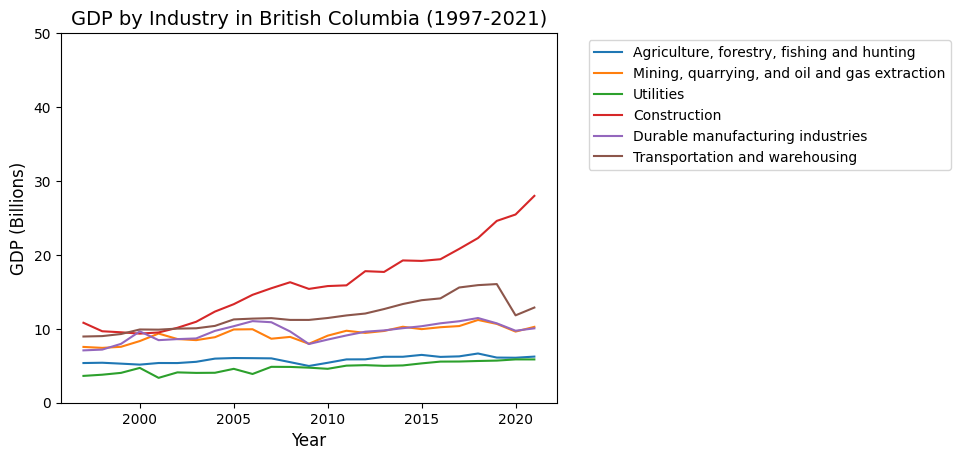

In [4]:
gdp = "BC_GDP_1997-2023.csv"
gdpdata = pd.read_csv(gdp, skiprows=3)

gdpdata = gdpdata.dropna(how='all', axis=1)
gdpdata = gdpdata.dropna(how='all', axis=0)

gdpdata = gdpdata.iloc[:82] # Retain rows 0 to 81 (inclusive)

gdpdata = gdpdata.rename(columns={"Unnamed: 0": "Year"}) # Rename the first column to "Years"

# Remove commas from numeric columns
for col in gdpdata.columns[1:]:
    gdpdata[col] = gdpdata[col].str.replace(',', '')

gdpdata.iloc[:, 1:] = gdpdata.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') # Convert numeric columns to float

# Set "Years" as index, transpose the dataframe and change values to floats
gdpdata = gdpdata.set_index("Year").T
gdpdata = gdpdata.astype(float)
gdpdata.index = gdpdata.index.astype(int)
# Restrict data from 1997 to 2021
gdpdata = gdpdata.loc['1997':'2021']

# Select the columns to plot
columns_to_plot = [
    "Agriculture, forestry, fishing and hunting",
    "Mining, quarrying, and oil and gas extraction",
    "Utilities",
    "Construction",
    "Durable manufacturing industries",
    "Transportation and warehousing",
    #"Real estate and rental and leasing",
]

# Ensure the columns exist in the data before plotting
columns_to_plot = [col for col in columns_to_plot if col in gdpdata.columns]

# Convert GDP units from millions to billions
gdpdata[columns_to_plot] = gdpdata[columns_to_plot] / 1000

# Plot the GDP data
plt.figure(figsize=(15, 10))
gdpdata[columns_to_plot].plot()

# Add labels and title
plt.title("GDP by Industry in British Columbia (1997-2021)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("GDP (Billions)", fontsize=12)
plt.yticks(ticks=range(0, 60, 10))

# Customize the legend and layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Show the plot
plt.show()

Here we are converting the GDP data into percentage change so we are looking at how different sector's GHG emission change has the impact on the growth rate of the correspongding sector.

In [5]:
gdpdata_perct = gdpdata.pct_change(fill_method=None)

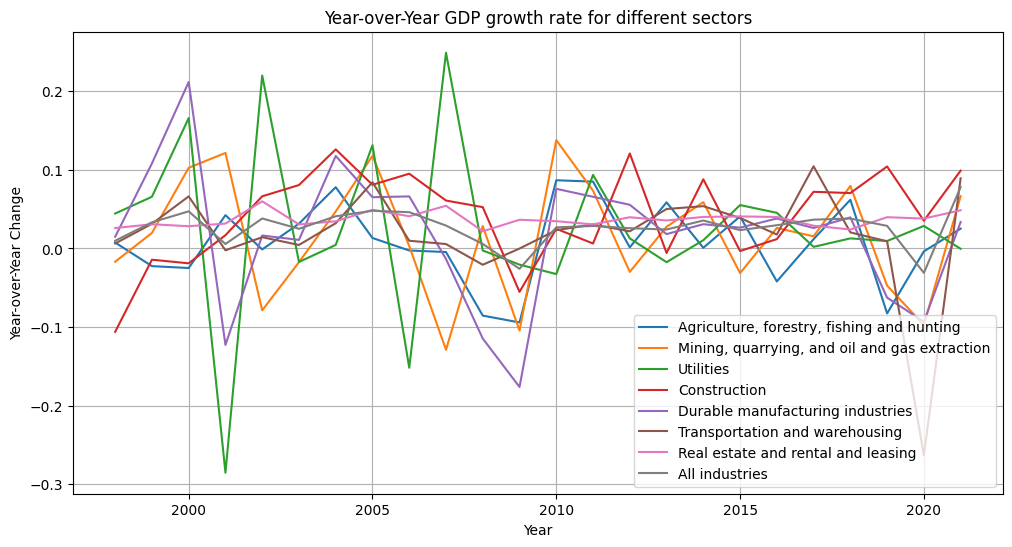

In [6]:
columns_to_plot = [
    "Agriculture, forestry, fishing and hunting",
    "Mining, quarrying, and oil and gas extraction",
    "Utilities",
    "Construction",
    "Durable manufacturing industries",
    "Transportation and warehousing",
    "Real estate and rental and leasing",
    "All industries"
]

# Create the plot
plt.figure(figsize=(12, 6))

for column in columns_to_plot:
    plt.plot(gdpdata_perct.index, gdpdata_perct[column], label=column)

plt.title('Year-over-Year GDP growth rate for different sectors')
plt.xlabel('Year')
plt.ylabel('Year-over-Year Change')
plt.legend(loc='best')
plt.grid(True)

Add either a individual year fixed effect or dummy variables to see if there is a correlation between how different years may effect the estimation, time fixed effect. Omit one of the years.

This part belongs to Tuan for him trying to make some more interesting stuff, but he responded due to his final, he cannot finish that in time.

### **Step 1: Visualizing Emissions Across Main Sectors**

#### Objective:
Here we are trying to plot the emissions of the 7 main sectors (marked green in the GHG dataset) along with the total emissions in BC to identify the subsectors contributing the most to GHG emissions. If the number of lines makes the graph cluttered, create two subplots for better clarity.

#### Actions:
- Generate a line plot for the 7 main sectors and the total emissions.
- Compare the top contributing sectors.
- Provide an interpretation of why these sectors contribute the most to BC’s emissions based on available data and potential underlying reasons.


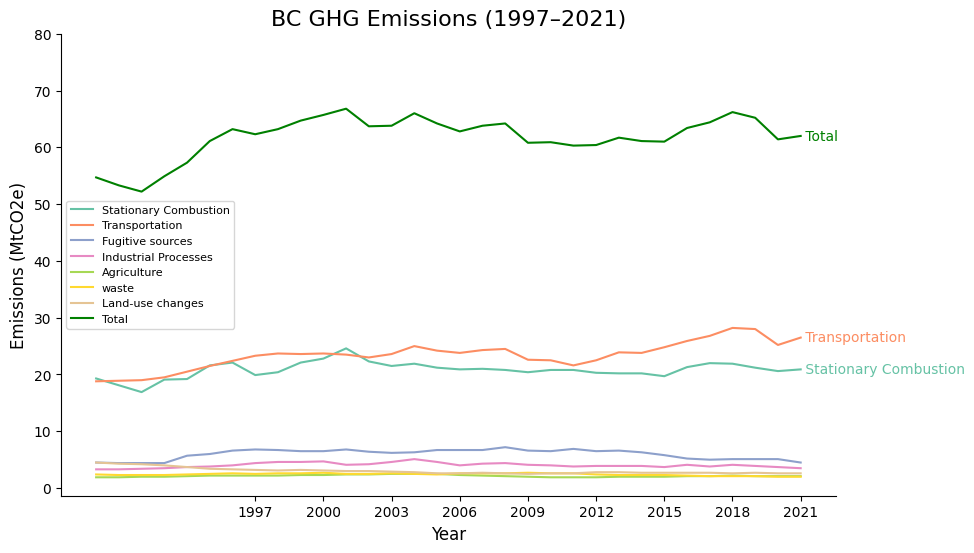

In [7]:
# Plot 7 main sectors, total vs "Year"
plt.figure(figsize=(10, 6))

plt.plot(df_filtered.index, df_filtered["Stationary Combustion"], label="Stationary Combustion", color="#66c2a5") #Energy Production
plt.plot(df_filtered.index, df_filtered["Transportation"], label="Transportation", color="#fc8d62")
plt.plot(df_filtered.index, df_filtered["FUGITIVE SOURCES"], label="Fugitive sources", color="#8da0cb")
plt.plot(df_filtered.index, df_filtered["INDUSTRIAL PROCESSES AND PRODUCT USE (IPPU)"], label="Industrial Processes", color="#e78ac3")
plt.plot(df_filtered.index, df_filtered["AGRICULTURE"], label="Agriculture", color="#a6d854")
plt.plot(df_filtered.index, df_filtered["WASTE"], label="waste", color="#ffd92f")
plt.plot(df_filtered.index, df_filtered["LAND-USE CHANGE"], label="Land-use changes", color="#e5c494")

plt.plot(df_filtered.index, df_filtered["Total"] , label="Total", color="green")
# Add labels, title, and legend
plt.title("BC GHG Emissions (1997–2021)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Emissions (MtCO2e)", fontsize=12)
plt.legend(fontsize=8)

# Add labels to the end of each line
columns_to_label = ["Transportation", "Total", "Stationary Combustion"]
colors = ["#fc8d62", "green", "#66c2a5"]
for col, color in zip(columns_to_label, colors):
    
    plt.text(
        df_filtered.index[-1],            # X-coordinate: Last year in the index
        df_filtered[col].iloc[-1],        # Y-coordinate: Last value in the column
        f" {col}",               # Add some padding with the label
        color=color,             # Use the same color as the line
        fontsize=10,
        verticalalignment="center",
    )


plt.yticks(ticks=range(0, 90, 10))
plt.xticks(ticks=range(1997, 2024, 3))

# Remove top and right spines
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

From the plot generated above, we can get some intuition: The top 2 sources contributing to the total emission, transportation and stationary combustion (like industrial processes, residential heating, and power generation), are often the main contributors to greenhouse gas (GHG) emissions in many regions, including British Columbia (BC), due to a variety of factors. We sugest the following possible reasons:

#### 1. Transportation
BC's transportation sector relies heavily on fossil fuels, with road vehicles like cars, trucks, and buses being major contributors. Urban areas like Vancouver, with dense populations and heavy traffic, see higher emissions. Geographically, BC’s size necessitates long-distance driving, particularly in rural areas with limited public transit options. While electric vehicle adoption is growing, gasoline-powered vehicles still dominate. Additionally, aviation—driven by tourism and business travel—adds significantly to emissions.

#### 2. Stationary Combustion
Building heating in BC often depends on natural gas, especially in colder regions, leading to significant CO2 emissions. Industrial sectors like forestry, mining, and manufacturing also rely on fossil fuels for energy and processes, contributing further to stationary emissions. Although BC’s electricity grid is predominantly hydroelectric, natural gas power plants still operate, particularly during periods of low water availability. Methane emissions from landfills, resulting from organic waste decomposition, further compound the issue.

#### 3. Contributing Factors and Trends
BC’s climate necessitates significant heating during winter, further increasing emissions from natural gas. Shipping and port operations also contribute, particularly in coastal areas. Despite progress in decarbonizing electricity generation, transportation and stationary combustion remain dominant sources of emissions due to reliance on fossil fuels and slower adoption of cleaner technologies.

#### What we can see for now:
Transportation and stationary combustion are the largest contributors to BC's GHG emissions, driven by fossil fuel dependency and long-standing energy practices. While cleaner technologies are gaining traction, these sectors continue to dominate the emission landscape.

### **Step 2: Comparing GHG Emissions with GDP Growth**

#### Objective:
Analyze the growth rate of different sectors correspongding to the 7 listed main sectors of GHG emission above and their corresponding sectors in the GDP dataset to understand their growth patterns. Investigate:
- Whether emissions and GDP growth align over time.
- Any lags or anomalies between emissions and GDP growth.
- Specific patterns in any sector worth further exploration.

Here, we somtimes combine different subsectors under the 7 large sectors of GHG emission (as you can see below for the MQOG data), trying to generate a more intuitive and accurate alignment between GHG emission data and the GDP growth rate of different sectors. 

#### Actions:
- Plot emissions and GDP growth for the top 6 sectors side by side.
- Identify correlations, lags, or deviations.
- Highlight interesting findings for sectors like AI or Electric Vehicles, even if not included in the GHG dataset.


In [8]:
columns_to_plot_gdp = [
    "Agriculture, forestry, fishing and hunting",
    "Mining, quarrying, and oil and gas extraction",
    "Utilities",
    "Construction",
    "Durable manufacturing industries",
    "Transportation and warehousing",
    "Real estate and rental and leasing",
]

columns_to_plot_ghg =[
    "Stationary Combustion",
    "Transportation",
    "FUGITIVE SOURCES",
    "INDUSTRIAL PROCESSES AND PRODUCT USE (IPPU)",
    "AGRICULTURE",
    "WASTE",
    "LAND-USE CHANGE"]

rows_to_sum_MQOG = [
    "Petroleum Refining Industries",
    "Oil and Gas Extraction",
    "Mining"
] #corresponded to "Mining, quarrying, and oil and gas extraction"


# Create a new row by summing the specified rows
new_row_MQOG = df_filtered[rows_to_sum_MQOG].sum(axis=1)
# Add the new row to the DataFrame
df_filtered["Mining, quarrying, and oil and gas extraction"] = new_row_MQOG

df_filtered_percent  = df_filtered.pct_change(fill_method=None)
row1 = "Petroleum Refining Industries"
row2 = "Oil and Gas Extraction"
row3 = "Mining"
df_filtered_percent = df_filtered_percent.T
#new_row_MQOG = df_filtered_w.loc[rows_to_sum_MQOG].sum()

# Sum the  rows
new_row_MQOG = df_filtered_percent.loc[row1] + df_filtered_percent.loc[row2] + df_filtered_percent.loc[row3]

# Add the new row to the DataFrame
df_filtered_percent.loc["Refining,Oil and Gas,Mining"] = new_row_MQOG
df_filtered_percent= df_filtered_percent.T
df_filtered_percent.head()

Year,Total,ENERGY,Stationary Combustion,Public Electricity and Heat Production,Petroleum Refining Industries,Oil and Gas Extraction,Mining,Manufacturing Industries,Construction,Commercial and Institutional,...,Forest Growth Minus Decay,Slash Pile Burning,Wildfires,Decomposition of Harvested Wood Products,Cropland Management,Wetland Management,Grassland Management,Settlement Management,"Mining, quarrying, and oil and gas extraction","Refining,Oil and Gas,Mining"
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,-0.025594,-0.025822,-0.062176,-0.375000,0.000000,-0.333333,0.000000,-0.046154,0.0,0.103448,...,0.007830,2.692308,-0.468085,0.160959,0.0,0.0,NaN,0.0,-0.179487,-0.333333
1992,-0.020638,-0.028916,-0.066298,0.800000,-0.166667,-0.500000,-0.333333,-0.112903,0.0,0.031250,...,-0.005549,-0.041667,-0.080000,0.191740,-1.0,0.0,NaN,0.0,-0.343750,-1.000000
1993,0.051724,0.069479,0.130178,1.222222,-0.300000,0.142857,0.250000,0.090909,0.0,0.121212,...,-0.006696,-0.119565,-0.826087,0.066832,inf,0.0,NaN,0.0,-0.047619,0.092857
1994,0.043716,0.053364,0.005236,-0.100000,0.000000,1.000000,-0.200000,0.033333,0.0,-0.081081,...,-0.005618,-0.197531,3.875000,0.018561,-3.0,0.0,NaN,0.0,0.350000,0.800000


### **Step 3: Exploring Key Sector Patterns**

#### Objective:
From the initial comparisons, identify 4 sectors with the most intriguing patterns for in-depth analysis.

#### Actions:
- Create detailed visualizations for each of the 4 selected sectors.
- Use subplots to compare their GHG emissions and GDP trends effectively.
- Interpret sector-specific growth patterns and any shared trends across all analyzed relationships.


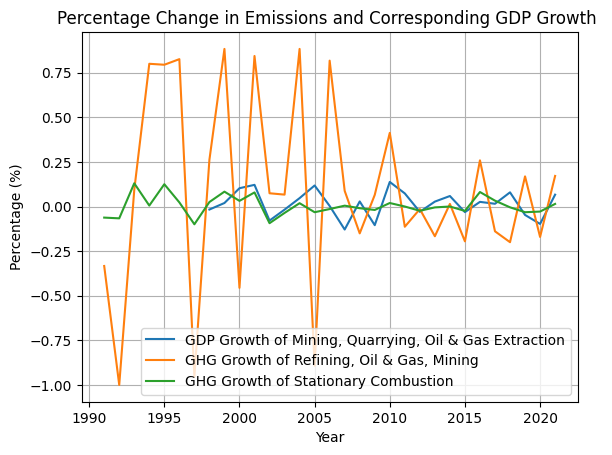

In [9]:

plt.plot(gdpdata_perct.index, 
         gdpdata_perct["Mining, quarrying, and oil and gas extraction"], 
         label="GDP Growth of Mining, Quarrying, Oil & Gas Extraction")

plt.plot(df_filtered_percent.index, 
         df_filtered_percent["Refining,Oil and Gas,Mining"], 
         label="GHG Growth of Refining, Oil & Gas, Mining")

plt.plot(df_filtered_percent.index, 
         df_filtered_percent["Stationary Combustion"], 
         label="GHG Growth of Stationary Combustion")


plt.xlabel("Year")  
plt.ylabel("Percentage (%)")  
plt.title("Percentage Change in Emissions and Corresponding GDP Growth ")  
plt.legend()
plt.grid(True)

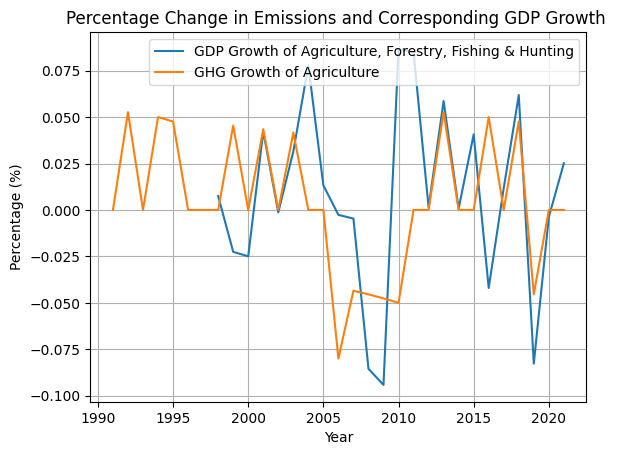

In [10]:
plt.plot(gdpdata_perct.index, 
         gdpdata_perct["Agriculture, forestry, fishing and hunting"], 
         label="GDP Growth of Agriculture, Forestry, Fishing & Hunting")

plt.plot(df_filtered_percent.index, 
         df_filtered_percent["AGRICULTURE"], 
         label="GHG Growth of Agriculture")


plt.xlabel("Year")  
plt.ylabel("Percentage (%)") 
plt.title("Percentage Change in Emissions and Corresponding GDP Growth ") 
plt.legend()
plt.grid(True)

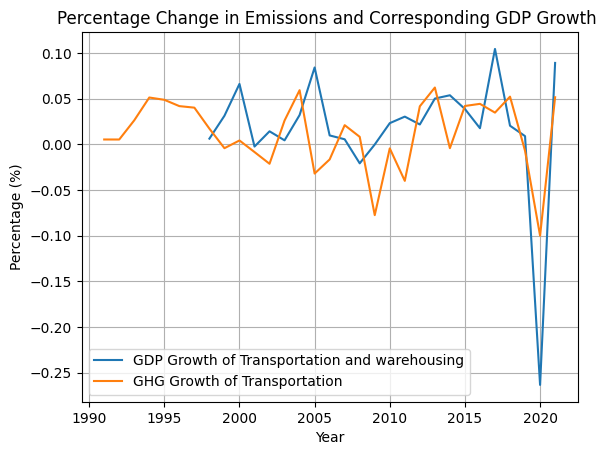

In [11]:

plt.plot(gdpdata_perct.index, 
         gdpdata_perct["Transportation and warehousing"], 
         label="GDP Growth of Transportation and warehousing")

plt.plot(df_filtered_percent.index, 
         df_filtered_percent["Transportation"], 
         label="GHG Growth of Transportation")



plt.xlabel("Year")  
plt.ylabel("Percentage (%)")  
plt.title("Percentage Change in Emissions and Corresponding GDP Growth ")  
plt.legend()
plt.grid(True)

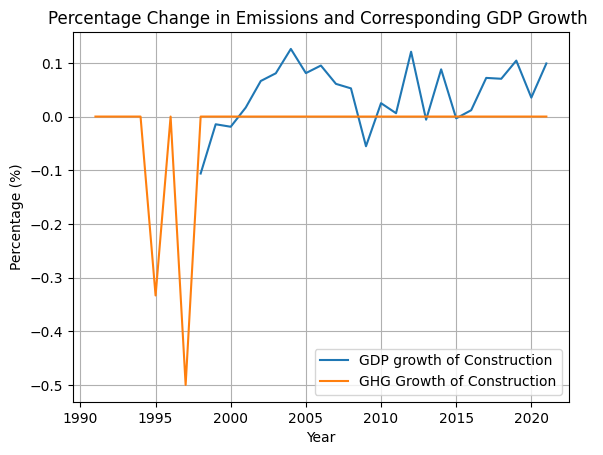

In [12]:
plt.plot(gdpdata_perct.index, 
         gdpdata_perct["Construction"], 
         label="GDP growth of Construction")

plt.plot(df_filtered_percent.index, 
         df_filtered_percent["Construction"], 
         label="GHG Growth of Construction")


plt.xlabel("Year")  
plt.ylabel("Percentage (%)") 
plt.title("Percentage Change in Emissions and Corresponding GDP Growth ") 
plt.legend()
plt.grid(True)

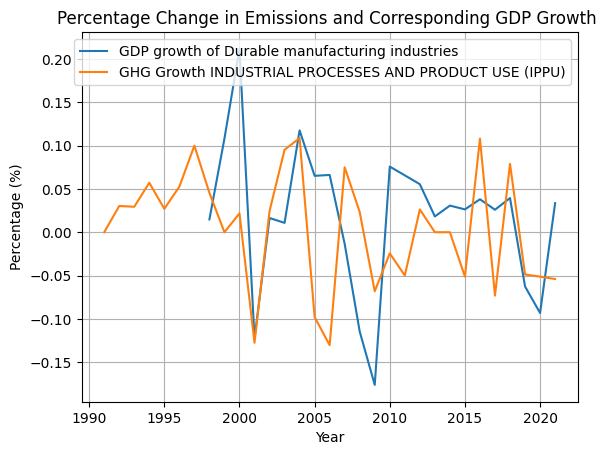

In [13]:
plt.plot(gdpdata_perct.index, 
         gdpdata_perct["Durable manufacturing industries"], 
         label="GDP growth of Durable manufacturing industries")

plt.plot(df_filtered_percent.index, 
         df_filtered_percent["INDUSTRIAL PROCESSES AND PRODUCT USE (IPPU)"], 
         label="GHG Growth INDUSTRIAL PROCESSES AND PRODUCT USE (IPPU)")


plt.xlabel("Year")  
plt.ylabel("Percentage (%)") 
plt.title("Percentage Change in Emissions and Corresponding GDP Growth ") 
plt.legend()
plt.grid(True)

In [14]:
gdpdata_perct.head()

Year,All industries,Goods-producing industries,"Agriculture, forestry, fishing and hunting",Crop and animal production,Forestry and logging,"Fishing, hunting and trapping",Support activities for agriculture and forestry,"Mining, quarrying, and oil and gas extraction",Oil and gas extraction,Mining and quarrying (except oil and gas),...,Accommodation and food services,Other services (except public administration),Public administration,Special Aggregations,Information and communication technology sector,"Information and communication technology, manufacturing","Information and communication technology, services",Energy sector,All industries (except cannabis sector),Cannabis sector
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,0.009733,-0.028595,0.007450,0.039610,0.014848,-0.331719,0.041237,-0.016958,-0.134973,0.077766,...,-0.008680,-0.004512,0.001600,NaN,0.105371,0.228395,0.091879,-0.034848,0.009183,0.096386
1999,0.033180,0.055643,-0.022555,0.069956,-0.059544,-0.221014,-0.056931,0.019677,0.122053,-0.070566,...,-0.009081,0.020398,0.034492,NaN,0.137205,0.633166,0.088200,0.051690,0.033148,0.038462
2000,0.047165,0.096192,-0.024967,-0.026270,-0.070912,0.102326,0.125984,0.102564,0.271323,-0.104138,...,0.022419,0.034551,0.020260,NaN,0.196338,0.815385,0.116758,0.175519,0.047310,0.025132
2001,0.005576,-0.034719,0.042289,0.179856,-0.012850,-0.172996,-0.075758,0.121434,0.087992,0.234396,...,0.009923,0.060592,0.020481,NaN,-0.020578,-0.264407,0.026873,-0.022281,0.004544,0.160000


In [15]:
merged_df = pd.merge(gdpdata_perct[columns_to_plot_gdp], df_filtered_percent["Total"], left_index=True, right_index=True)
merged_df = merged_df.drop(index=merged_df.index[0])
merged_df.head()



,"Agriculture, forestry, fishing and hunting","Mining, quarrying, and oil and gas extraction",Utilities,Construction,Durable manufacturing industries,Transportation and warehousing,Real estate and rental and leasing,Total
1998,0.007450,-0.016958,0.044365,-0.106139,0.014826,0.006253,0.025924,0.014446
1999,-0.022555,0.019677,0.065699,-0.014377,0.108112,0.031292,0.030718,0.023734
2000,-0.024967,0.102564,0.165883,-0.018995,0.211703,0.066172,0.028221,0.015456
2001,0.042289,0.121434,-0.285411,0.016795,-0.122798,-0.002422,0.031575,0.016743
2002,-0.001303,-0.078781,0.219911,0.066281,0.016421,0.014264,0.059883,-0.046407


### **Step 4: Building a Predictive Model for Total GHG Emissions**

#### Objective:
Use the GDP data of selected sectors to predict BC’s total GHG emissions using a multi-linear regression model. With the intuition we generated before, here we try to build a model that selects the varibales with prediction power of the total GHG emission of BC. The best model that we could coose is LASSO, which with the optimization problem solved by lasso regression can be written as

$$
\min_{\beta} {|| X \beta - y||_2}^2 + {\alpha {|| \beta ||_1}}
$$


where $ || a ||_1 = \sum_{i=1}^N | a_i| $ is the [l1-norm](http://mathworld.wolfram.com/L1-Norm.html) and $ \alpha $ is called the regularization parameter.

Comparing to normal Multi-regression model which uses all the variable, or the backward-stepwise method that is much slower, the additional term penalizes large coefficients and in practice, effectively sets coefficients to zero
for features that are not informative about the
target.


#### Actions:
- Justify the selection of independent variables based on their relevance to emissions.
- Apply the LASSO method to identify the most impactful variables.
- Build and fine-tune a regression model to achieve the highest prediction accuracy.


In [16]:
#1.we need to first standardlize our data
scaler = StandardScaler()
scaler_df_array = scaler.fit_transform(merged_df)
scaler_df = pd.DataFrame(scaler_df_array, columns=merged_df.columns, index = merged_df.index)
train_scalered_df  = scaler_df.sample(frac = 0.8,random_state = 1) 
test_scalered_df = scaler_df.drop(train_scalered_df.index)
#splite our data
x_train = train_scalered_df[columns_to_plot_gdp]
y_train = train_scalered_df["Total"] 
x_test = test_scalered_df[columns_to_plot_gdp]
y_test = test_scalered_df["Total"]
#find best alpha 
lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
lasso_model = linear_model.Lasso(alpha =  lasso.alpha_) 
lasso_model.fit(x_train,y_train)
lasso_model.predict(x_test)

beta_0 = lasso_model.intercept_
beta_1 = lasso_model.coef_[0]
beta_2 = lasso_model.coef_[1]
beta_3 = lasso_model.coef_[2]
beta_4 = lasso_model.coef_[3]
beta_5 = lasso_model.coef_[4]
beta_6 = lasso_model.coef_[5]
beta_7 = lasso_model.coef_[6]

columns_to_plot_gdp = [
    "Agriculture, forestry, fishing and hunting",
    "Mining, quarrying, and oil and gas extraction",
    "Utilities",
    "Construction",
    "Durable manufacturing industries",
    "Transportation and warehousing",
    "Real estate and rental and leasing",
]


mse_l = metrics.mean_squared_error(y_train,lasso_model.predict(x_train))
print(f"MSE for trainning: {mse_l:.4f}")
mse_test_l = metrics.mean_squared_error(y_test,lasso_model.predict(x_test))
print(f"MSE for testing: {mse_test_l :.4f}")
print(f"Fit model: increase_ghg = {beta_0:.4f} + "
      f"{beta_1:.4f} * Agriculture, forestry, fishing and hunting + "
      f"{beta_2:.4f} * Mining, quarrying, and oil and gas extraction + "
      f"{beta_3:.4f} * Utilities + "
      f"{beta_4:.4f} * Construction + "
      f"{beta_5:.4f} * Durable manufacturing industries + "
      f"{beta_6:.4f} * Transportation and warehousing + "
      f"{beta_7:.4f} * Real estate and rental and leasing")

MSE for trainning: 0.2987
MSE for testing: 1.9150
Fit model: increase_ghg = 0.0728 + -0.0000 * Agriculture, forestry, fishing and hunting + 0.0000 * Mining, quarrying, and oil and gas extraction + -0.3414 * Utilities + -0.0000 * Construction + 0.2579 * Durable manufacturing industries + 0.3182 * Transportation and warehousing + -0.3727 * Real estate and rental and leasing


In [17]:
#lasso_model = linear_model.Lasso() #default value of alpha = 1
#lasso_model.fit(x, y) #the ones on the right are OLS

#lasso_coefs = pd.Series(dict(zip(list(x), lasso_model.coef_)))
#lr_coefs = pd.Series(dict(zip(list(x), lr_model.coef_)))
#coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
#coefs

In [30]:
lasso_model.fit(x_train,y_train)

lasso_coefs = pd.Series(dict(zip(list(x_train), lasso_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs))
coefs


,lasso
"Agriculture, forestry, fishing and hunting",-0.000000
"Mining, quarrying, and oil and gas extraction",0.000000
Utilities,-0.341369
Construction,-0.000000
Durable manufacturing industries,0.257920
Transportation and warehousing,0.318158
Real estate and rental and leasing,-0.372694


#### Intuitions:

1. **Utilities (-0.341369):**
   - Negative coefficient suggests decreases in emissions as utility sector activity increases
   - Possible reasons: improved efficiency, transition to cleaner energy sources

2. **Durable manufacturing industries (0.257920):**
   - Positive coefficient implies increased emissions with higher manufacturing activity
   - Likely due to energy-intensive processes and materials used

3. **Transportation and warehousing (0.318158):**
   - Positive coefficient indicates higher emissions with increased activity
   - Consistent with heavy reliance on fossil fuels in transportation

4. **Real estate and rental and leasing (-0.372694):**
   - Negative coefficient suggests decreased emissions with increased sector activity
   - Possible explanations: energy-efficient buildings, sustainable practices


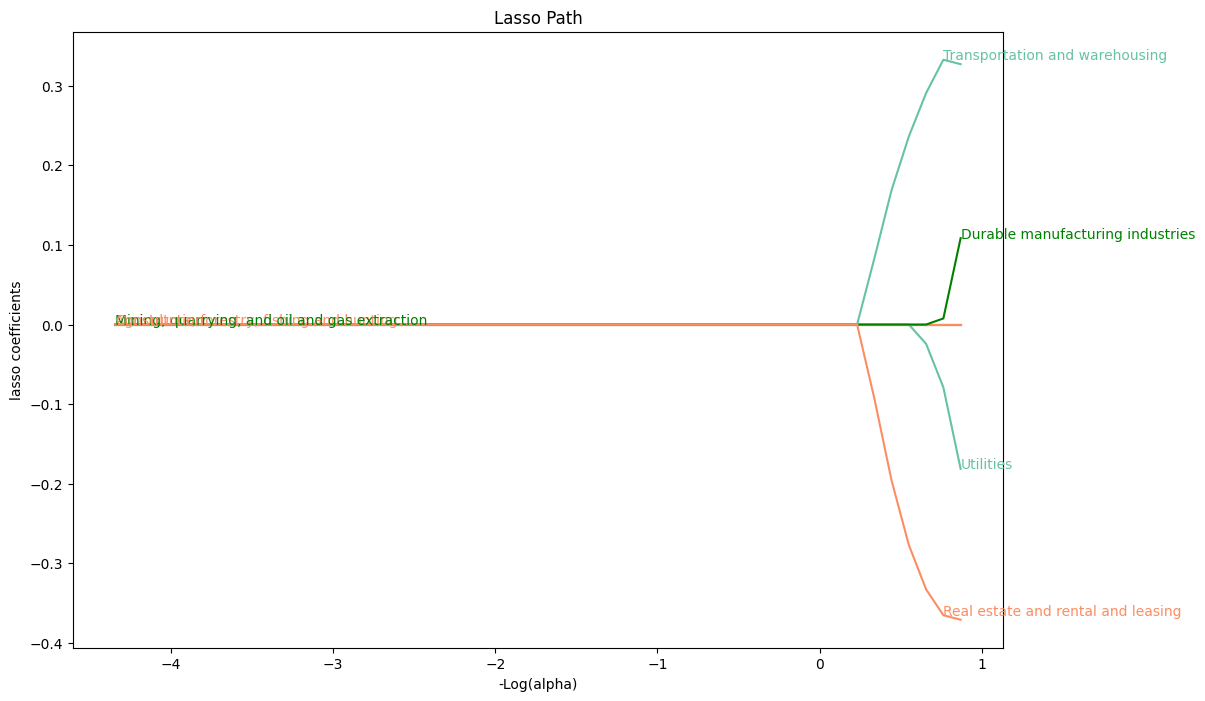

In [31]:
# Compute lasso for many alphas (the lasso path)
from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(x_train, y_train, alphas=alphas, max_iter=10000)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, list(x_train)):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)

In [32]:
def fit_and_report_mses(mod, x_train, x_test, y_train, y_test):
    mod.fit(x_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(x_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(x_test))
    )

fit_and_report_mses(linear_model.LinearRegression(), x_train, x_test, y_train, y_test)

{'mse_train': np.float64(0.23184792552480954),
 'mse_test': np.float64(3.1663167275846105)}

Here we can see, that the multi-linear regretion generates a big MSE of 3.166 for the testing data set.

Text(-2.3688789921995554, 0.9678170750560687, 'train')

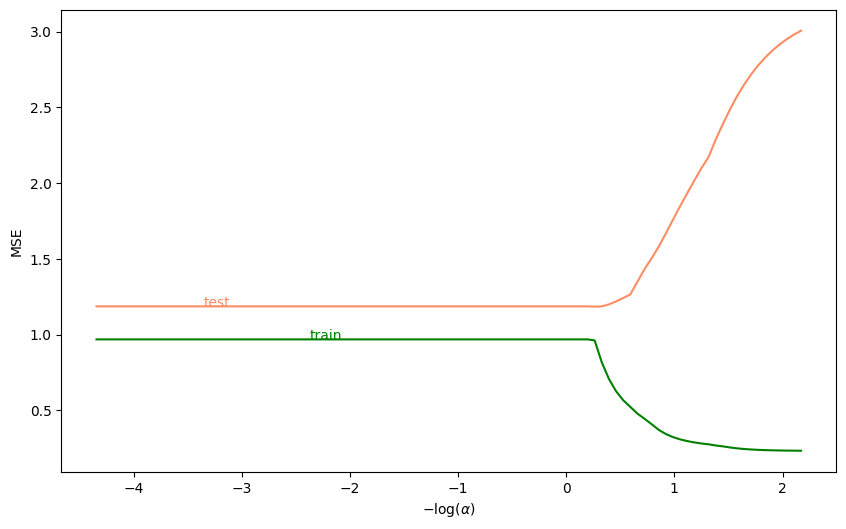

In [33]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           x_train, x_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
fig, ax = plt.subplots(figsize=(10,6))
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])

In [34]:
fit_and_report_mses(linear_model.Lasso(), x_train, x_test, y_train, y_test) #drastcially improved the MSE. 

{'mse_train': np.float64(0.9678170750560687),
 'mse_test': np.float64(1.1858623096426109)}

While we can see here that the MSE for the testing dataset's MSE has been shrinked down to 1.186, which is much smaller than before. 

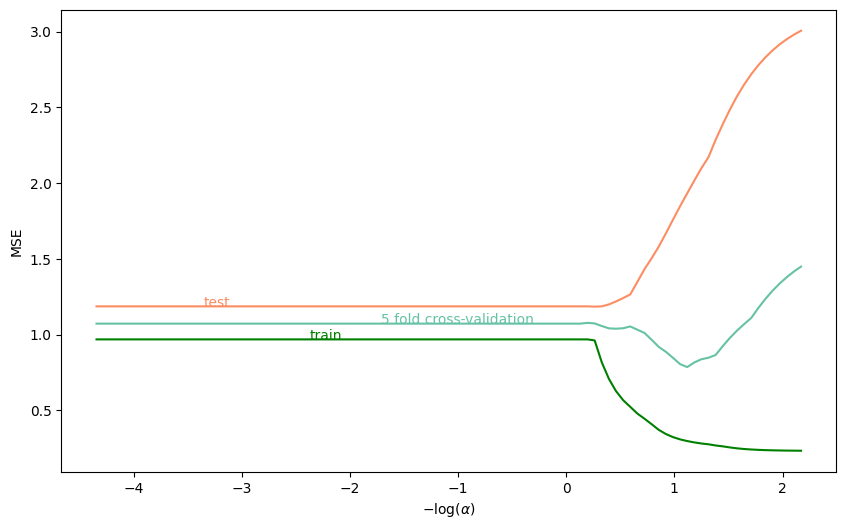

In [35]:
from sklearn.model_selection import cross_val_score #plotting several testing set as one line
mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.annotate("5 fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])
ax.get_legend().remove()
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
fig

In [41]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
-np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting


np.float64(1.1054658346274304)

In [37]:
lasso.alpha_

np.float64(0.07843938236796198)

From the model we see that the optimum alpha calculated which technically gives us the minimum MSE for the dataset locates around 1.1 after fitting it to th 5 fold cross-validation process. This alpha is calculated after -log(\alpha), which gives us a real alpha value of 0.07844.

In [38]:
fit_and_report_mses(linear_model.Lasso(alpha = lasso.alpha_), x_train, x_test, y_train, y_test)

{'mse_train': np.float64(0.298669710012569),
 'mse_test': np.float64(1.9150079570728251)}

In [39]:
#lasso_model = linear_model.Lasso(alpha = lasso.alpha) #default value of alpha = 1
#lasso_model.fit(x, y) #the ones on the right are OLS

#lasso_coefs = pd.Series(dict(zip(list(x), lasso_model.coef_)))
#lr_coefs = pd.Series(dict(zip(list(x), lr_model.coef_)))
#coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
#coefs

Here we use the optimum alpha to generate the variables that the model sees as significant in the prediction power of total GHG emission. From the form generated, we can see that......

In [40]:
#plt.close('all') 
#fig, ax = plt.subplots(figsize=(12, 8))
#from sklearn.model_selection import cross_val_score
#colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']

#alphas = np.exp(np.linspace(1, -5, 100))
#mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
#                                  x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
#          for alpha in alphas]
#mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
#ax.annotate("5 fold cross-validation", (mse.log_alpha[30], mse.cv[30]), color=colors[2])
#ax.get_legend().remove()
#ax.set_xlabel(r"$-\log(\alpha)$")
#ax.set_ylabel("MSE")

### **Summary of Coding Goals**

The project will culminate in:
1. Visual insights into BC’s top-emitting sectors.
2. Analysis of the relationship between emissions and GDP growth.
3. Detailed investigation of 4 key sectors and their patterns.
4. A machine learning-based predictive model to estimate BC’s total GHG emissions.


## Results

### Key Findings:
1. The top sectors contributing to BC's emissions include:
   - [Insert specific sectors and their contribution percentages.]
2. There is a significant [positive/negative] relationship between [specific sectors] emissions and their GDP growth.

### Predictive Model:
- The LASSO regression model demonstrates that [list significant predictors] are key determinants of BC's total emissions.
- The model achieves an accuracy of [insert model performance metrics].

### Data Visualizations:
- [Insert key visualizations or dashboards summarizing the results.]


## Discussion

### Policy Implications:
1. The findings suggest that policies targeting [specific sectors] can significantly reduce emissions.
2. Encouraging sustainable growth in sectors with high emissions intensity could balance economic development with environmental goals.

### Limitations:
1. The analysis is constrained by the availability of data from [years].
2. The predictive model assumes linear relationships, which may not fully capture the complexity of emissions dynamics.

### Future Research:
1. Incorporate more advanced Machine Learning techniques to improve predictive accuracy.
2. Explore additional factors influencing emissions, such as technological innovations and policy interventions.


## Conclusion

This project highlights the critical role of specific sectors in contributing to BC's carbon emissions and demonstrates the potential of data-driven models to predict emissions and guide policy decisions. By combining data visualization, statistical modeling, and Machine Learning, the team provides actionable insights to address environmental challenges and promote sustainable growth.

Under the guidance of **Dr. Philip Solimine** and **TA Derek Caughy**, this project bridges academic learning with real-world applications, emphasizing the importance of sustainability in economic modeling.


## Acknowledgments

We would like to thank **Dr. Philip Solimine** and **TA Derek Caughy** for their invaluable guidance and support throughout this project. Their insights and feedback were instrumental in shaping our analysis and results.
